In [1]:
import zipfile
import os
import rasterio
from rasterio import features
import numpy as np
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

300

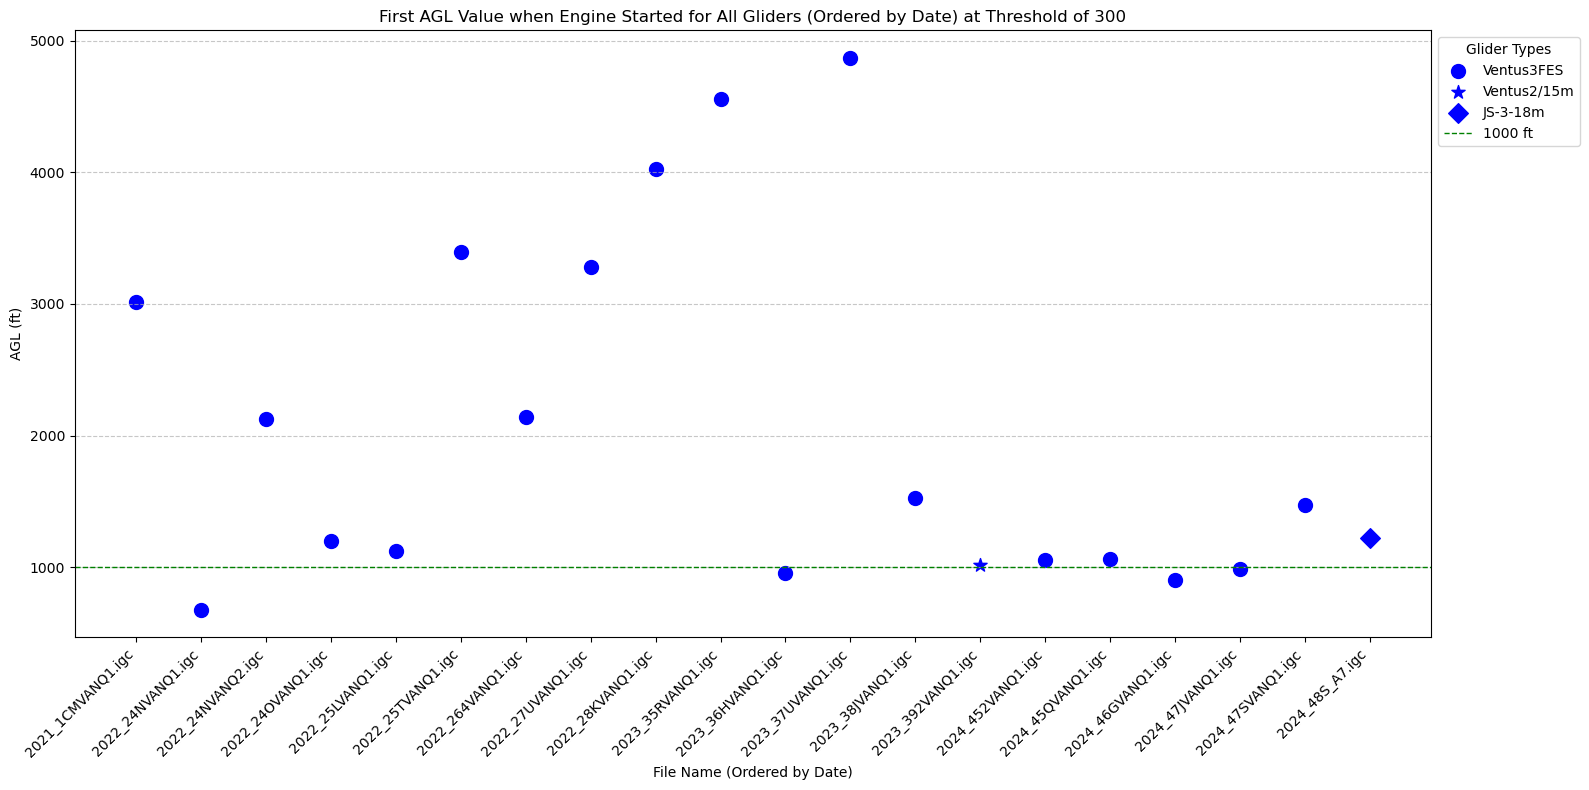

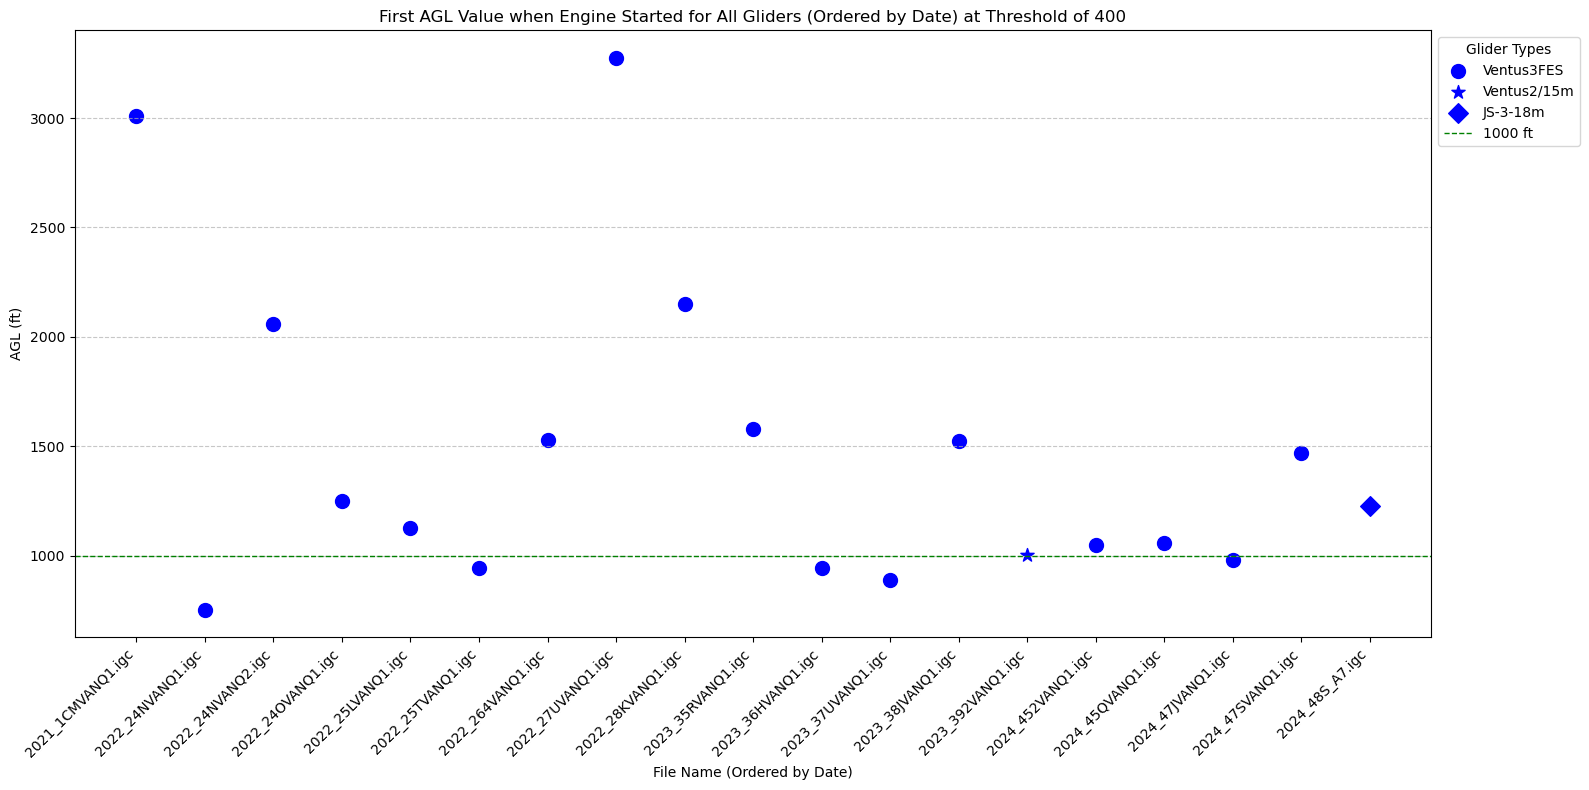

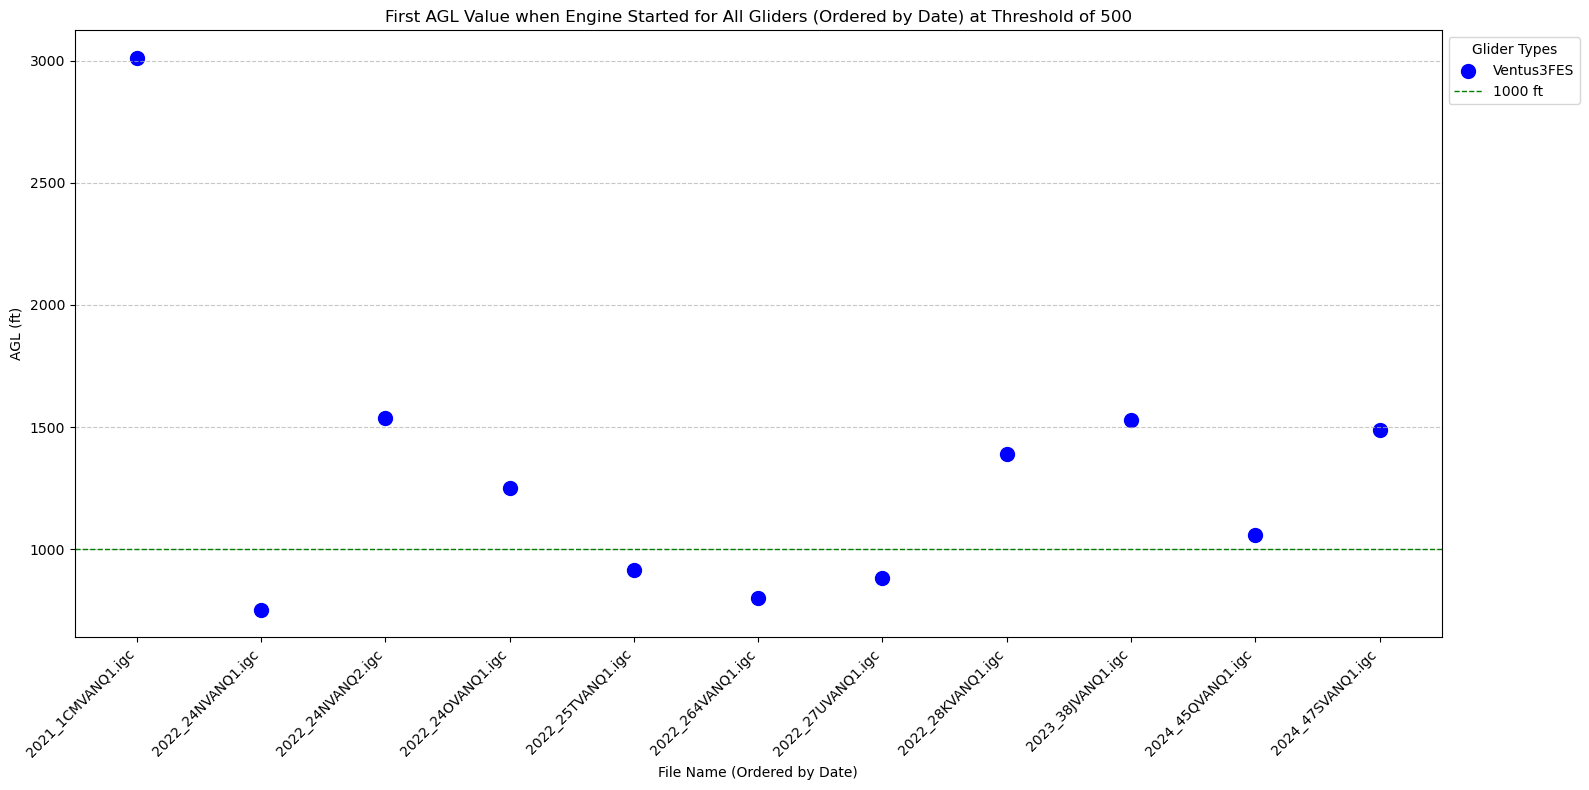

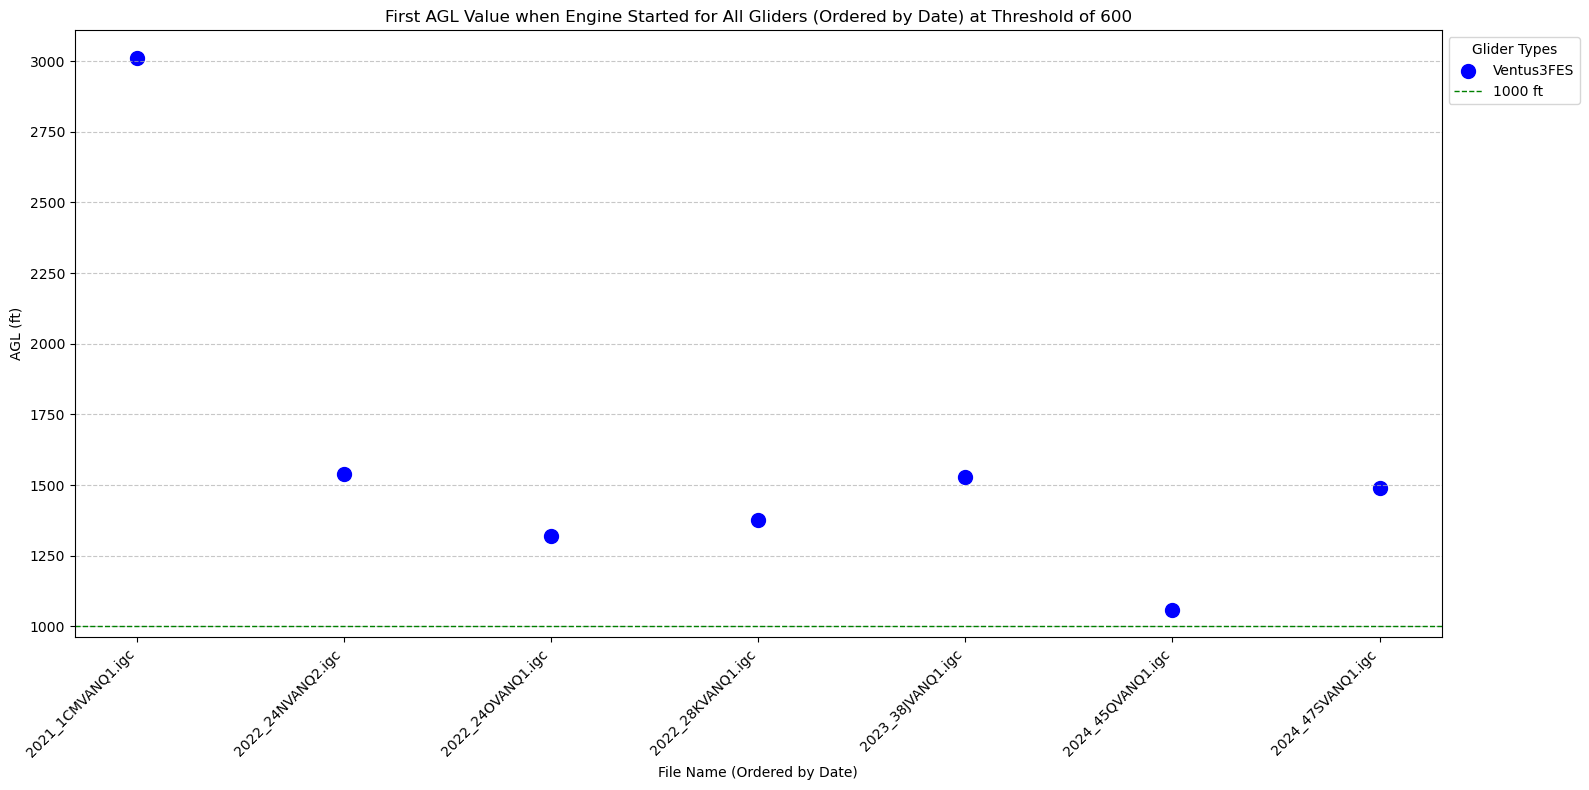

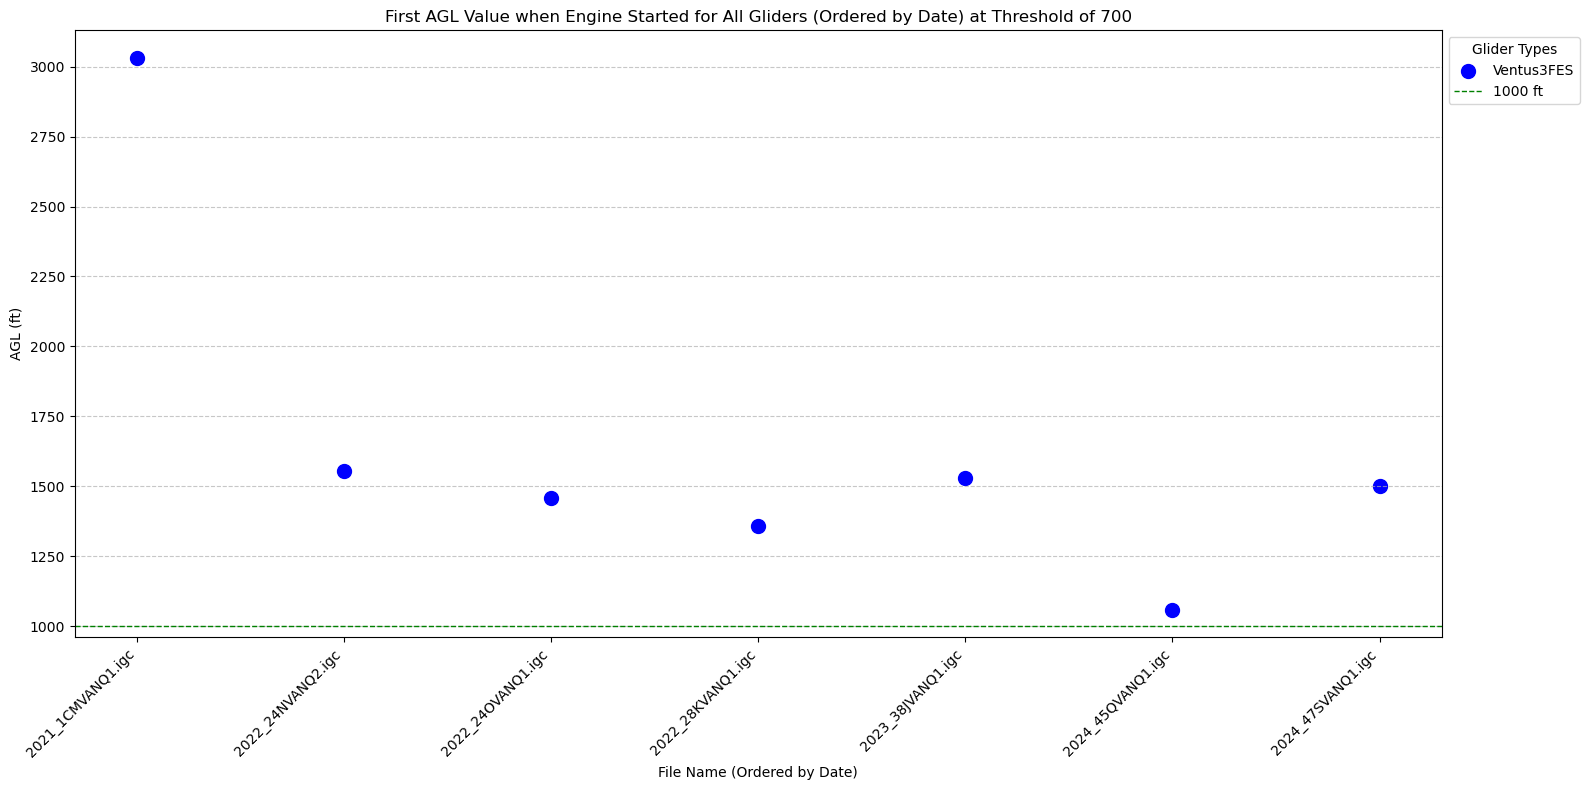

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import re

# Define file paths for all thresholds
thresholds = [300, 400, 500, 600, 700]
file_paths_by_threshold = {
    threshold: {
        '2019': f'Flt-times_2019_{threshold}.csv',
        '2020': f'Flt-times_2020_{threshold}.csv',
        '2021': f'Flt-times_2021_{threshold}.csv',
        '2022': f'Flt-times_2022_{threshold}.csv',
        '2023': f'Flt-times_2023_{threshold}.csv',
        '2024': f'Flt-times_2024_{threshold}.csv'
    }
    for threshold in thresholds
}

# Define marker map for glider types
marker_map = {
    "Ventus3FES": "o",
    "ASK-21": "s",
    "JS-3-18m": "D",
    "ASH31/21m": "^",
    "ASW-27": "v",
    "Discus-2c": "P"
}

# Loop through each threshold and process the files
for threshold, file_paths in file_paths_by_threshold.items():
    # Combine data across years for the current threshold
    all_years_df = pd.concat([pd.read_csv(file) for file in file_paths.values()], ignore_index=True)

    # Extract relevant data
    file_labels = []
    agl_all_first_values = []
    glider_types = []
    dates = []

    for year, file_path in file_paths.items():
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            info = row['Sensor Info']
            glider_type = row['Gtype']
            date = pd.to_datetime(row['Date (MM/DD/YYYY)'], format='%m/%d/%Y')
            if pd.notna(info):
                # Extract MOP or RPM sensor values
                matches = re.findall(r'(MOP|RPM) sensor at t=\[.*?\] and \[([\d, ]+)\]AGL', info)
                if matches:
                    # Extract the first value and corresponding sensor type
                    sensor, values = matches[0]
                    first_value = int(values.split(', ')[0])
                    agl_all_first_values.append(first_value)
                    file_labels.append(f"{year}_{row['File']}")  # Use year and file name as label
                    glider_types.append(glider_type)
                    dates.append(date)

    # Create a DataFrame to sort by date
    data = pd.DataFrame({
        'Date': dates,
        'File Label': file_labels,
        'AGL': agl_all_first_values,
        'Glider Type': glider_types
    })

    # Sort data by date
    data = data.sort_values(by='Date', ascending=True).reset_index(drop=True)

    # Plotting
    plt.figure(figsize=(16, 8))

    # Create a set to keep track of glider types for the legend
    plotted_glider_types = set()

    for idx, row in data.iterrows():
        marker = marker_map.get(row['Glider Type'], "*")  # Default marker if type not in map

        # Plot each point with the same color
        plt.scatter(idx, row['AGL'], color='b', marker=marker, s=100, 
                    label=row['Glider Type'] if row['Glider Type'] not in plotted_glider_types else None)

        # Add glider type to the set once plotted
        plotted_glider_types.add(row['Glider Type'])

    plt.axhline(y=1000, color='g', linestyle='--', linewidth=1, label='1000 ft')

    # Set x-ticks to be more frequent (every few points)
    plt.xticks(ticks=range(0, len(data), max(1, len(data)//40)), labels=data['File Label'][::max(1, len(data)//40)], rotation=45, ha='right')

    plt.xlabel('File Name (Ordered by Date)')
    plt.ylabel('AGL (ft)')
    plt.title(f'First AGL Value when Engine Started for All Gliders (Ordered by Date) at Threshold of {threshold}')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(title="Glider Types", loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()
